In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys
from collections import defaultdict


In [2]:
env = gym.make('Blackjack-v0')

In [3]:
def sample_policy(observation):
    """
    sticks if player score is >= 17 and hits otherwise
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 17 else 1

In [4]:
def mc_prediction(policy, env, num_episodes, gamma):
    
    
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    V = defaultdict(float)
    
    for i_episode in range(1, num_episodes + 1):
        
        
        episode = []
        state = env.reset()
        for t in range(100):
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

       
        states_in_episode = set([tuple(x[0]) for x in episode])
        for state in states_in_episode:
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state)
            G = sum([x[2]*(gamma**i) for i,x in enumerate(episode[first_occurence_idx:])])
            returns_sum[state] += G
            returns_count[state] += 1.0
            V[state] = returns_sum[state] / returns_count[state]

    return V

In [5]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # Let us monitor our progress :)
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            
            
        # Generating an episode using our 80-20 policy we defined above:
        episode = generate_episode(env)
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        '''
        This discounts array is the amount by which we wanna discount each consequent reward ie.
        discounts = [1,gamma, gamma^2, gamma^3.....] 
        then we compute the total return Gt= Rt+1 *1 + Rt+2 * gamma + Rt+3 * gamma^2 +...
        '''
        discounts = np.array([gamma**i for i in range(len(rewards)+1)]) 
        # update the sum of the returns, number of visits, and action-value 
        # function estimates for each state-action pair in the episode
        for i, state in enumerate(states): #ever-visit
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            #Just taking the mean of all the returns got by taking this action when we were in this state.
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q

In [6]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset() #here, bj_env is the env instance
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [7]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

Episode 500000/500000.

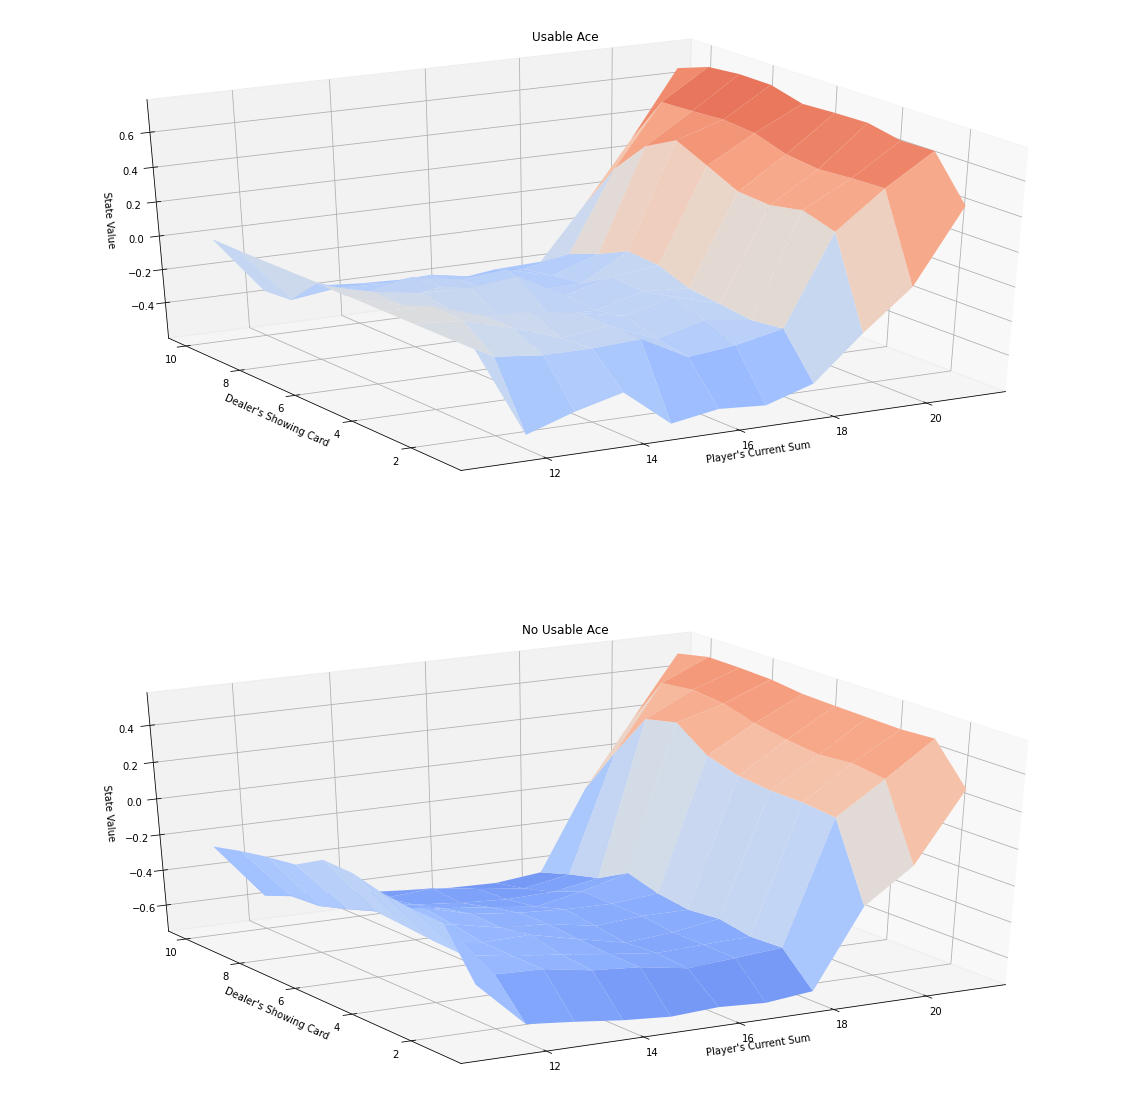

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()
    
# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)   

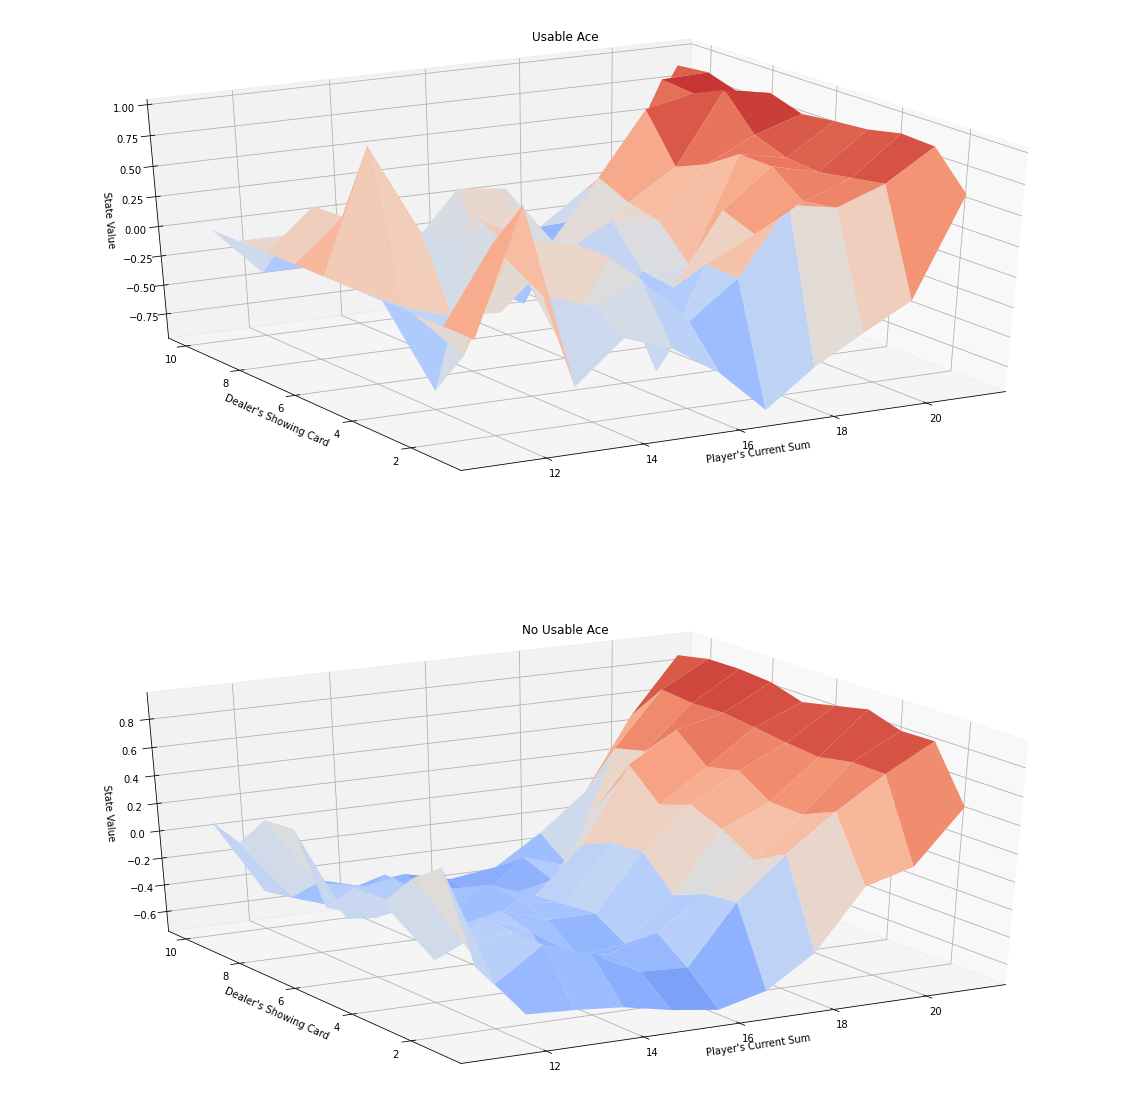

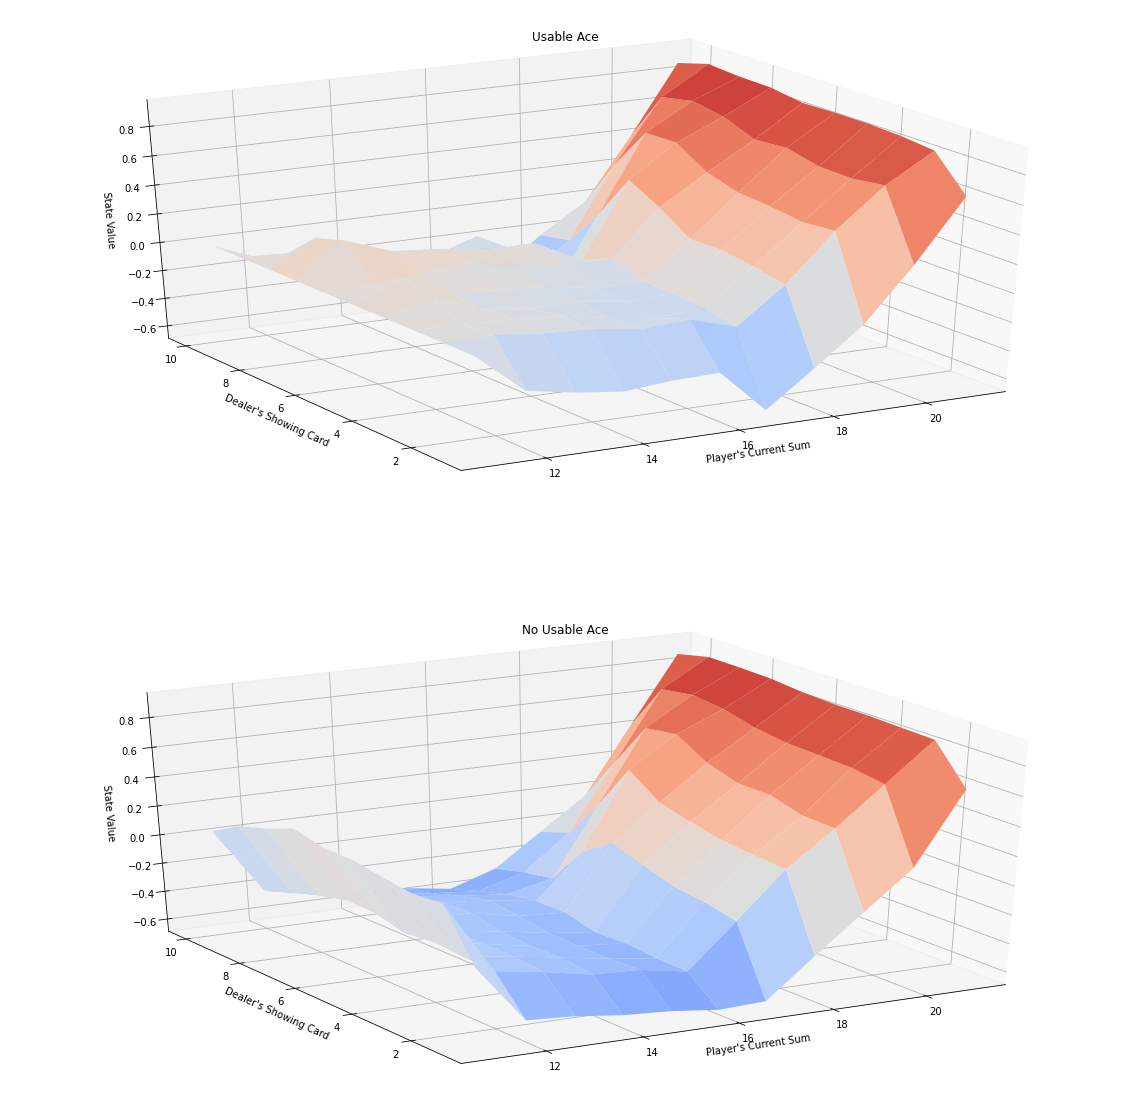

In [11]:
V_10k = mc_prediction(sample_policy, env, num_episodes=10000, gamma = 1.0)
plot_blackjack_values(V_10k)
sum(V_10k.values())

V_500k = mc_prediction(sample_policy, env, num_episodes=500000, gamma = 1.0)
plot_blackjack_values(V_500k)

In [15]:
print(V_10k)

defaultdict(<class 'float'>, {(20, 1, False): 0.13157894736842105, (16, 2, False): -0.5, (12, 2, False): -0.42424242424242425, (20, 10, False): 0.4957805907172996, (13, 4, False): -0.1686746987951807, (12, 4, False): -0.43820224719101125, (12, 5, False): -0.1368421052631579, (7, 5, False): -0.16666666666666666, (11, 5, False): 0.043478260869565216, (15, 6, False): -0.3163265306122449, (18, 5, False): 0.32456140350877194, (20, 6, False): 0.7131147540983607, (13, 10, True): -0.4146341463414634, (13, 10, False): -0.42045454545454547, (17, 4, False): -0.19827586206896552, (14, 10, False): -0.517426273458445, (14, 5, False): -0.2619047619047619, (16, 10, False): -0.5573333333333333, (17, 10, False): -0.5104166666666666, (14, 1, False): -0.5959595959595959, (14, 1, True): -0.15384615384615385, (19, 1, False): 0.03529411764705882, (20, 5, False): 0.680672268907563, (18, 9, False): -0.4625, (12, 9, False): -0.4268292682926829, (9, 8, False): 0.029411764705882353, (12, 8, False): -0.23170731707

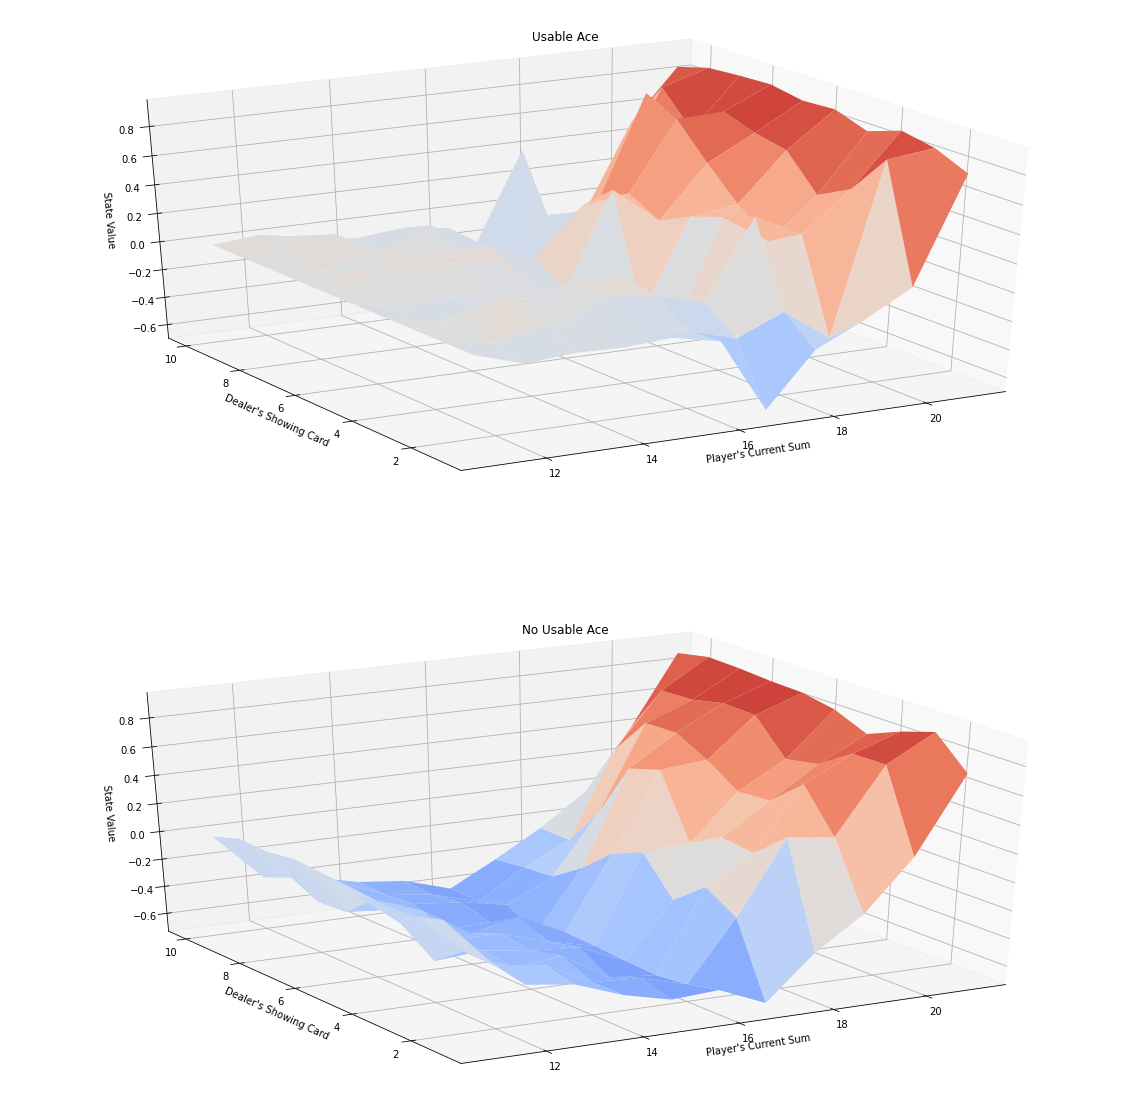

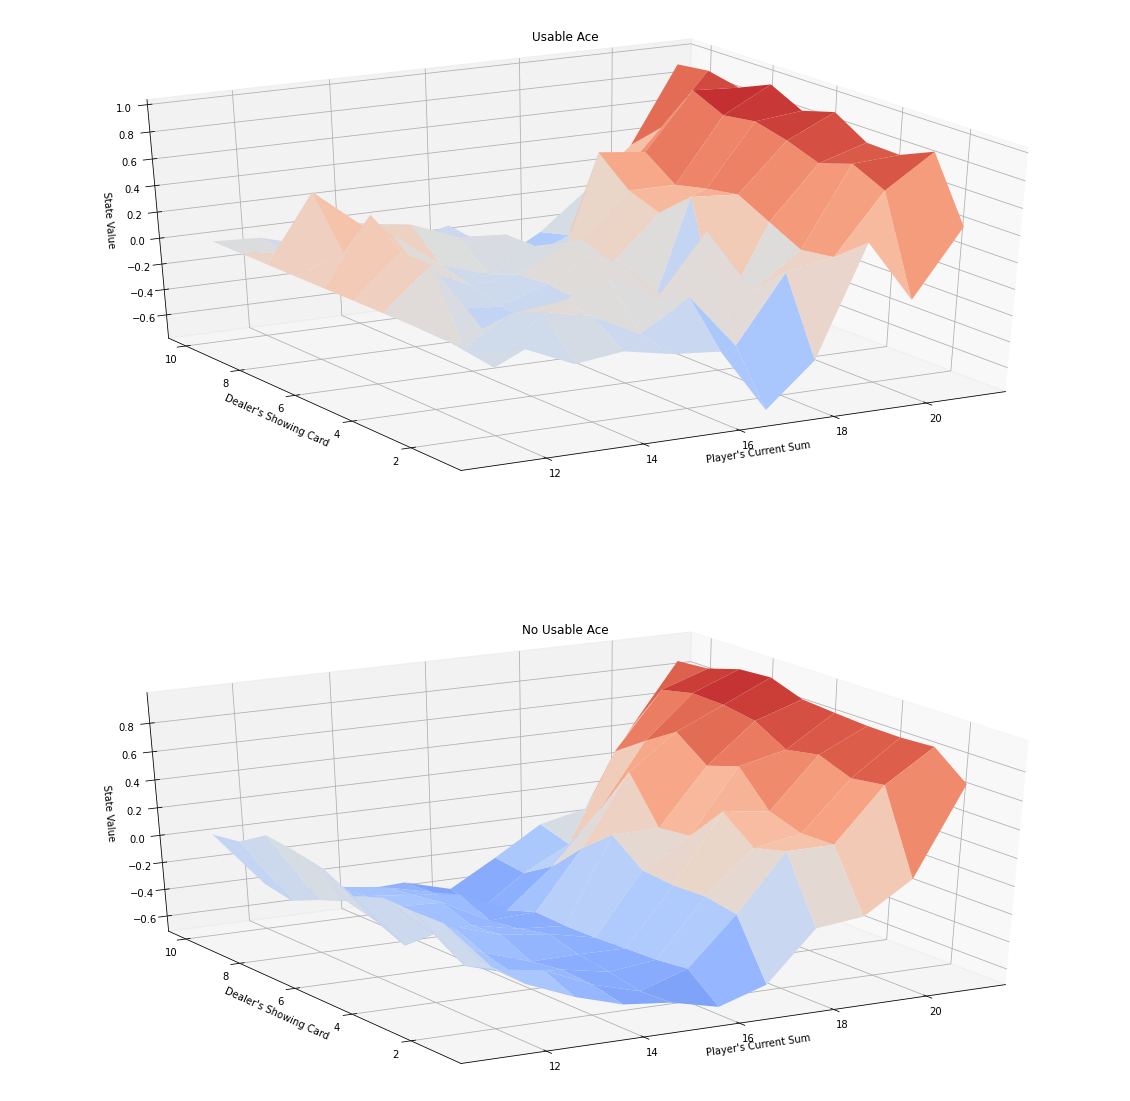

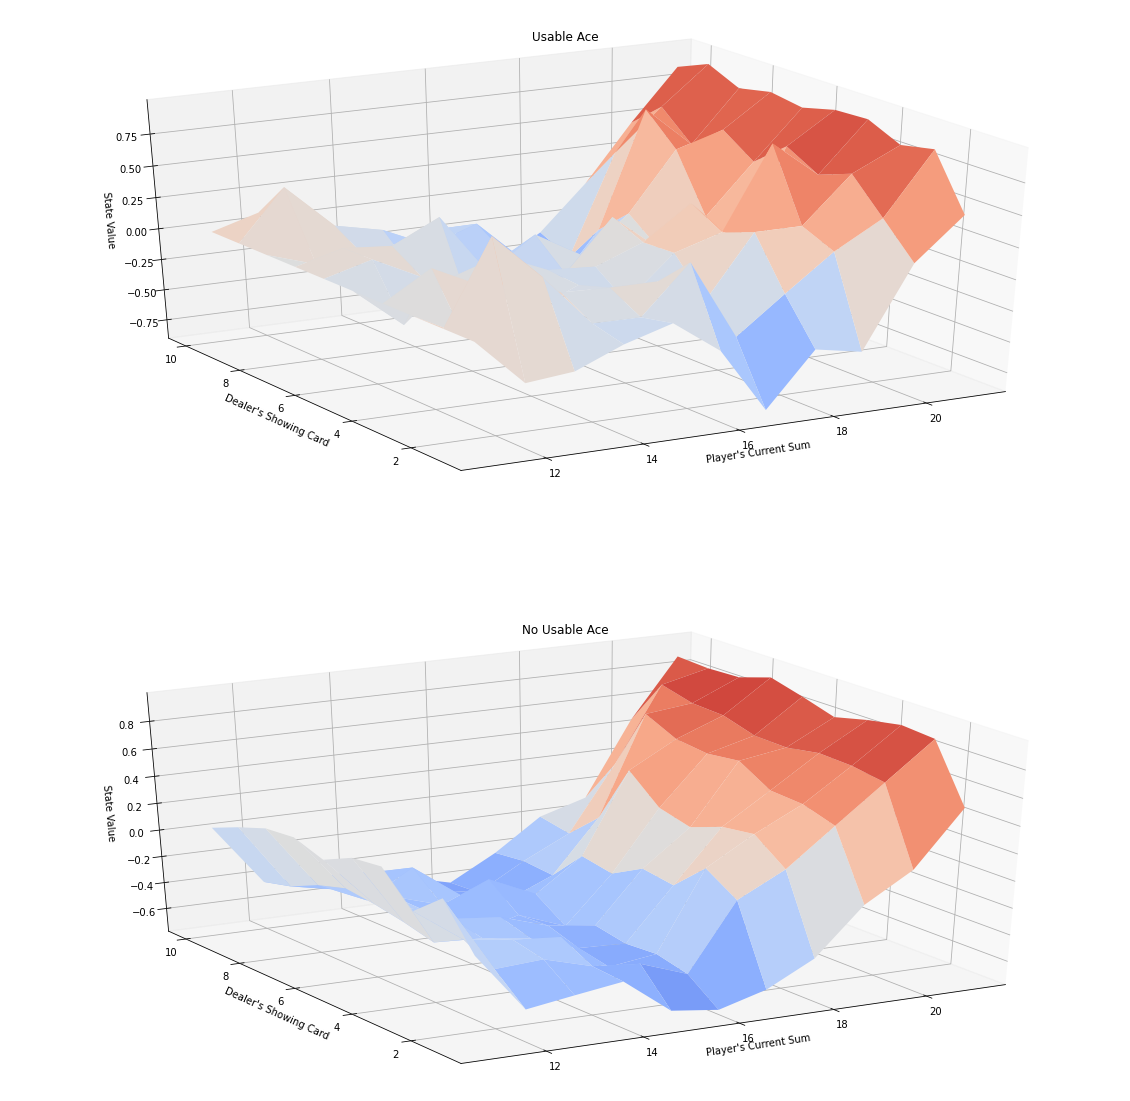

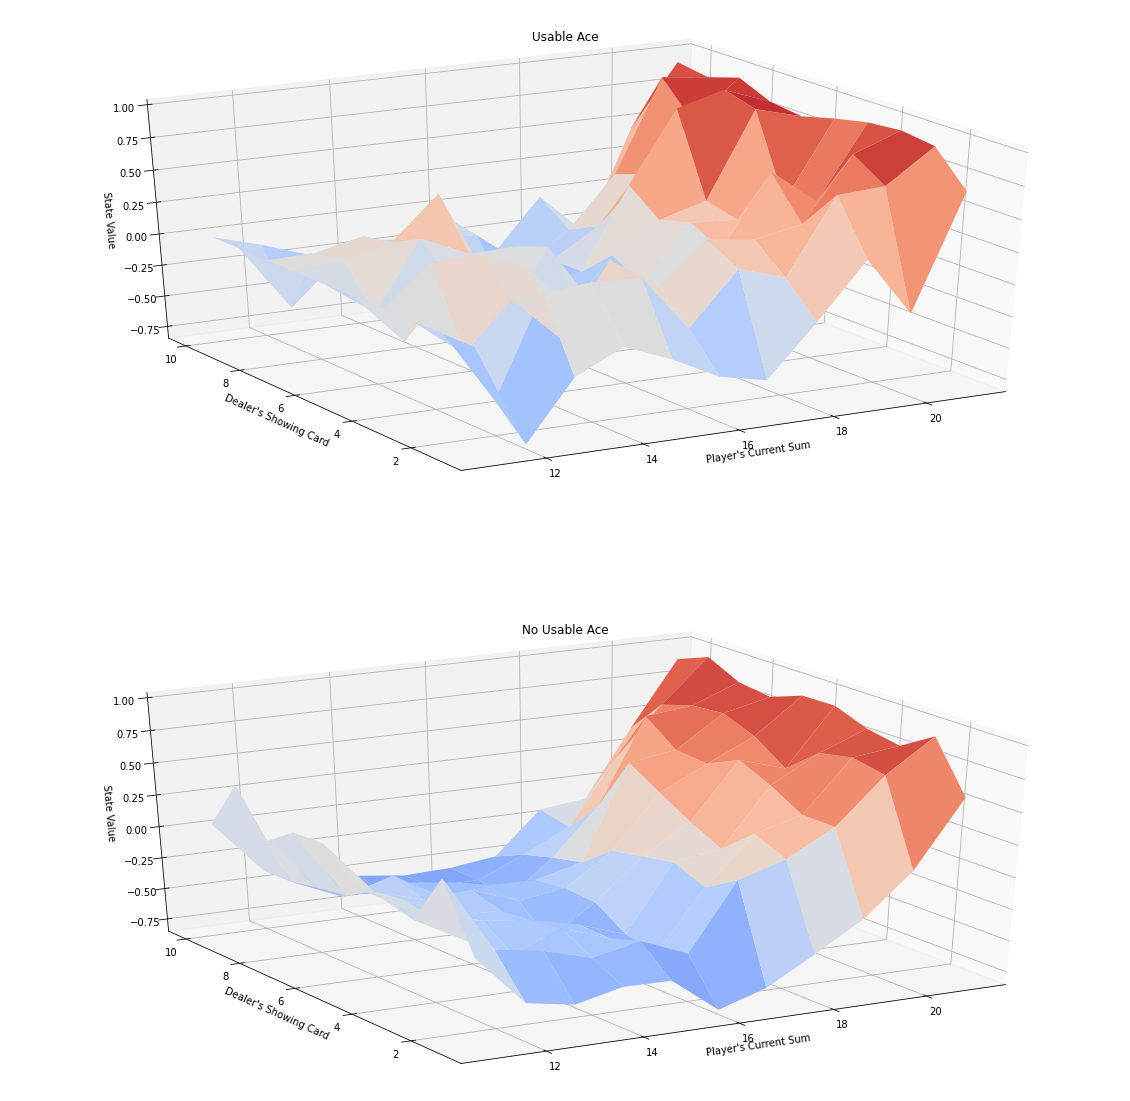

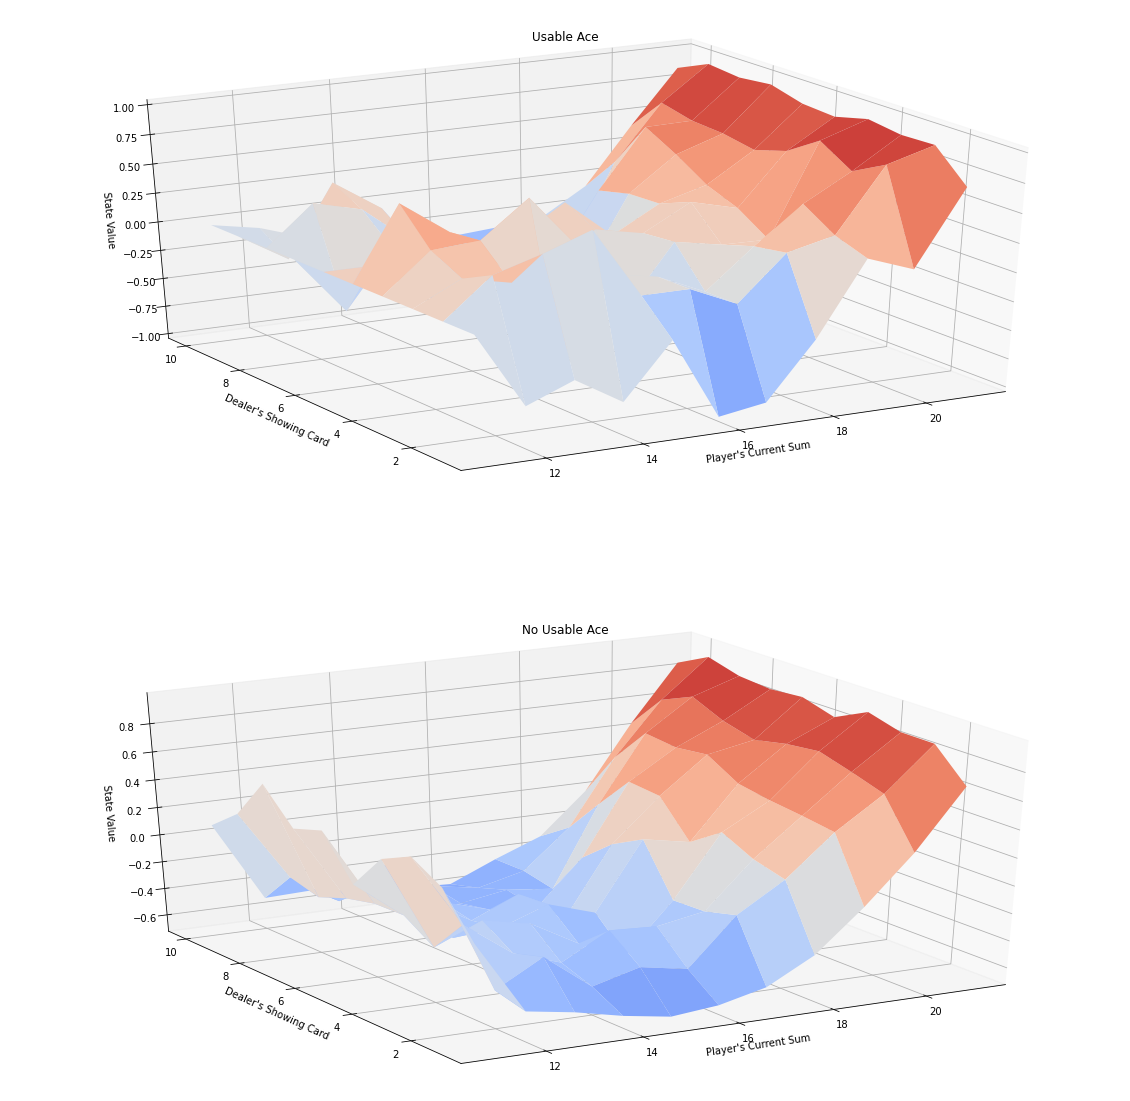

In [16]:


r = [0.3, 0.5, 0.8, 0.9, 1.0]
for g in r:
  V = mc_prediction(sample_policy, env, num_episodes=10000, gamma = g)
  plot_blackjack_values(V)


In [18]:
def get_probs(Q_s, epsilon, nA): #nA is no. of actions in the action space
    # obtains the action probabilities corresponding to epsilon-greedy policy
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

In [19]:
nA=env.action_space.n
for i_episode in range(10):
    state = env.reset()
    while True:
        print(state)
        action = np.random.choice(np.arange(nA), p=get_probs(V[state], 0, nA)) \
                                    if state in V else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        state = next_state
        if done:
            print('Game has ended! Your Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(7, 7, False)
Game has ended! Your Reward:  -1.0
You lost :(

(14, 9, False)
Game has ended! Your Reward:  -1.0
You lost :(

(12, 3, False)
Game has ended! Your Reward:  1.0
You won :)

(18, 6, False)
Game has ended! Your Reward:  1.0
You won :)

(15, 4, False)
Game has ended! Your Reward:  1.0
You won :)

(19, 2, False)
Game has ended! Your Reward:  -1.0
You lost :(

(18, 5, False)
Game has ended! Your Reward:  1.0
You won :)

(20, 8, False)
Game has ended! Your Reward:  1.0
You won :)

(13, 10, False)
Game has ended! Your Reward:  -1.0
You lost :(

(16, 10, False)
Game has ended! Your Reward:  -1.0
You lost :(



In [22]:
  V = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

nA=env.action_space.n
for i_episode in range(10):
    state = env.reset()
    while True:
        print(state)
        action = np.random.choice(np.arange(nA), p=get_probs(V[state], 0, nA)) \
                                    if state in V else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        state = next_state
        if done:
            print('Game has ended! Your Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

Episode 500000/500000.(14, 6, False)
Game has ended! Your Reward:  -1.0
You lost :(

(16, 6, False)
Game has ended! Your Reward:  -1.0
You lost :(

(7, 3, False)
Game has ended! Your Reward:  -1.0
You lost :(

(10, 10, False)
(20, 10, False)
Game has ended! Your Reward:  1.0
You won :)

(18, 10, True)
Game has ended! Your Reward:  1.0
You won :)

(16, 5, False)
Game has ended! Your Reward:  1.0
You won :)

(15, 10, False)
Game has ended! Your Reward:  -1.0
You lost :(

(14, 6, True)
(16, 6, True)
(16, 6, False)
Game has ended! Your Reward:  1.0
You won :)

(16, 9, False)
Game has ended! Your Reward:  1.0
You won :)

(16, 5, False)
Game has ended! Your Reward:  -1.0
You lost :(

